In [1]:
import numpy as np
from numpy import random
import pandas as pd
import sympy as sp
from sympy import symbols,diff, simplify, integrate, oo,mellin_transform,Function
from sympy.stats import cdf, Normal

import math
from math import pow, exp, sqrt
from scipy import stats
norm = stats.norm

import timeit
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.special import erf

In [ ]:
from bsopm import BSOPM_Class

## A Butterfly Spread

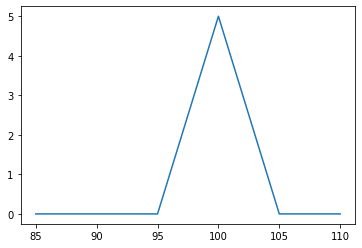

In [4]:
class ButterflySpread:
  def spread_payoff(self,K_low,K_mid,K_high,St,call):
    strikes = [K_low,K_mid,K_high]
    weights = [1,-2,1]
    #func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).payoff
    func = lambda k : BSOPM_Class(S0=St,r=self.r,sigma=self.sigma,t=self.t,T=self.T,K=k,call=call).price
    vfunc = np.vectorize(func)
    port_value = vfunc(strikes)@weights
    return port_value

  def spread_price_range(self,K_low,K_mid,K_high,prices,call):
    func = lambda S : self.spread_payoff(K_low,K_mid,K_high,S,call)
    vfunc = np.vectorize(func)
    value_range = vfunc(prices)
    value_dict = {k:v for k,v in zip(prices,value_range)}  
    return value_dict

  def __init__(self,r,sigma,t,T,K_mid,delta,price_range,call=True): 
    self.r=r
    self.sigma=sigma
    self.T=T
    self.t=t
    #self.K_high=K_high
    #self.K_low=K_low
    #self.K_diff=self.K_high-self.K_low
    #self.K_mid=(self.K_high+self.K_low)/2
    self.K_mid=K_mid
    self.delta=delta 
    self.K_low=self.K_mid-self.delta
    self.K_high=self.K_mid+self.delta
    self.price_range=price_range
    self.call=call
    self.value_range=self.spread_price_range(self.K_low,self.K_mid,self.K_high,self.price_range,self.call)

St = 100
prices = np.arange(85,110+1)
r = 0.03
sigma = 0.3
T = 1
K_mid = 100
delta = 5
t=1
call=True
bf_spread = ButterflySpread(r,sigma,t,T,K_mid,delta,prices,call=call)
plt.plot(*zip(*bf_spread.value_range.items()))
plt.show()

## Proving Carr and Madan (2015) Approximation

In [5]:
S_sub=random.randint(10,200)
T_sub=random.uniform(0,1)
F_sub=random.randint(1,200)

S,F,K=symbols('S F K',real=True)
fwd=(S-K)/K
log_cont=sp.log(S/F)

first_deriv=diff(log_cont,S)
second_deriv=diff(first_deriv,S)
call=sp.Max(S-K,0)
put=sp.Max(K-S,0)

put_int=integrate(put*second_deriv.subs({S:K}),(K,0,F)) 
call_int=integrate(call*second_deriv.subs({S:K}),(K,F,oo)) 

rep_port=put_int.subs({S:S_sub,F:F_sub})+call_int.subs({S:S_sub,F:F_sub})
rep_port+=log_cont.subs({S:F_sub,F:F_sub})
#rep_port += ( (sp.Max(S-F,0)-sp.Max(F-S,0))*first_deriv ).subs({S:S_sub,F:F_sub})
rep_port+=(sp.Max(S-F,0)-sp.Max(F-S,0)).subs({S:S_sub,F:F_sub})*first_deriv.subs({S:F_sub,F:F_sub})

print(f'S: {S_sub}')
print(f'F: {F_sub}')
print(f'payoff of replicating portfolio: {float(log_cont.subs({S:S_sub,F:F_sub}))}')
print(f'payoff of log contract: {float( rep_port )}' )


S: 59
F: 197
payoff of replicating portfolio: -1.205666284832269
payoff of log contract: -1.205666284832269


## Replicating Arbitrary Derivatives with Butterfly Spreads

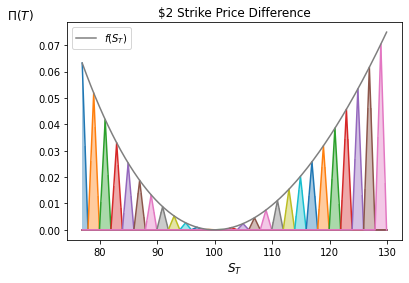

In [42]:
S0=100
r=0.03
sigma=0.3
T=1
t=T
S_ref=S0*np.exp(r*T) 
K_width=2
delta=K_width/2
call=True
S_diff=0.25
#K_diff

ST = np.arange(S0/1.3,S0*1.3,S_diff)
strike_range = np.arange(S0/1.3,S0*1.3,K_width)
def repl_func(ST,S0,T):
  payoffs=((ST/S0)-1)-np.log(ST/S0)
  payoffs*=2*T
  return payoffs

for k in strike_range:
  bf_payoff=ButterflySpread(r=r,sigma=sigma,t=t,T=T,K_mid=k,delta=delta,price_range=ST,call=call)
  spread_payoffs=list(bf_payoff.value_range.values())
  scale_factor=repl_func(k,S0,T)/delta
  scaled_payoffs=[p*scale_factor for p in spread_payoffs]
  plt.fill_between(ST,scaled_payoffs, step="mid", alpha=0.4)
  plt.plot(ST,scaled_payoffs)

plt.plot(ST,repl_func(ST,S0,T),label=r'$f(S_T)$')
plt.legend()
plt.ylabel(r'$\Pi(T)$',size=12,rotation='horizontal',loc='top') 
plt.xlabel('$S_T$',size=12)
plt.title(f'${K_width} Strike Price Difference')
plt.show()


## Variance Exposure of the Log Contract

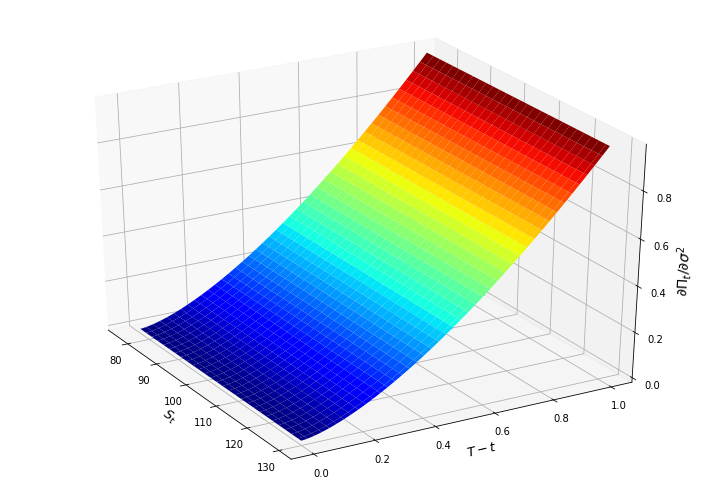

In [29]:
S=100
K=100
S_diff=1
sigma=0.3
T=1
St=np.arange(S/1.3,S*1.3,S_diff)
tau=T-np.linspace(0,T,252)
strikes=np.arange(1,S*5,1)

def vega_exposure(S,K,sigma,tau):
    v=sigma**2
    r=0.03
    #def bs_d1(S,K,v):
    #  d1=np.log(S/K)
    #  d1+=(0.03+v/2)*tau
    #  d1/=np.sqrt(v*tau)
    #  return d1
    #d1=bs_d1(S,K,v)
    d1=BSOPM_Class(S0=S,r=r,sigma=sigma,t=0,T=tau,K=K,call=True).d1
    vega=np.exp(-d1**2/2)
    vega/=(math.pi*2)**(1/2)
    vega*=S/(2*v**(1/2))
    vega*=tau
    return vega

def portfolio_vega(S,strikes,sigma,tau,T):
  indv_vegas=[vega_exposure(S,k,sigma,tau) for k in strikes]
  weights=[1/k**2 for k in strikes]
  tot_vega=np.array(indv_vegas).T@np.array(weights)
  tot_vega*=2/T
  return tot_vega

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.dist = 13
prices, timeline = np.meshgrid(St, tau)
vega=np.array(portfolio_vega(np.ravel(prices),strikes,sigma,np.ravel(timeline),T))
vega = vega.reshape(prices.shape)

surf = ax.plot_surface(prices, timeline, vega,cmap=cm.jet)
ax.set_xlabel('$ S_t $',fontsize=13)
ax.set_ylabel('$ T-t $',fontsize=13)
ax.set_zlabel(r'$ \partial \Pi_t / \partial \sigma^2 $',fontsize=14)
fig.set_size_inches(10, 7)
plt.tight_layout()
ax.view_init(None,-30)
plt.show()


## Recovering Risk-Neutral Probabilities (Breeden and Litzenberger Formula)

In [59]:
r=0.03 #annualized riskless rate 
sigma=0.3 #annualized volatility
T=3 #Time of Maturity
t=T #Current Time
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
call=True
dK = 0.1 #Width of a Butterfly Spread (or the $ difference between consecutive strikes)
delta = dK
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

probaility space sums to: 100.00000000008669%


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,PDF,probability
0,100,0.03,0.3,0.1,0.9,1.0,1.1,0,99.1,99.0,98.9,0.000000e+00,0.000000e+00,0.000000e+00
1,100,0.03,0.3,0.1,1.0,1.1,1.2,0,99.0,98.9,98.8,-1.421085e-14,-1.421085e-12,-1.421085e-13
2,100,0.03,0.3,0.1,1.1,1.2,1.3,0,98.9,98.8,98.7,1.421085e-14,1.421085e-12,1.421085e-13
3,100,0.03,0.3,0.1,1.2,1.3,1.4,0,98.8,98.7,98.6,-1.421085e-14,-1.421085e-12,-1.421085e-13
4,100,0.03,0.3,0.1,1.3,1.4,1.5,0,98.7,98.6,98.5,1.421085e-14,1.421085e-12,1.421085e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,100,0.03,0.3,0.1,299.5,299.6,299.7,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2987,100,0.03,0.3,0.1,299.6,299.7,299.8,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2988,100,0.03,0.3,0.1,299.7,299.8,299.9,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2989,100,0.03,0.3,0.1,299.8,299.9,300.0,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00


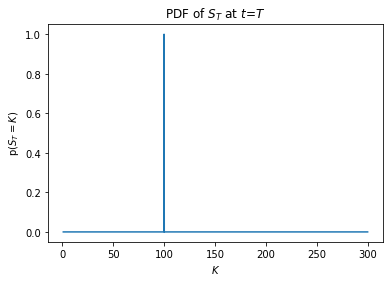

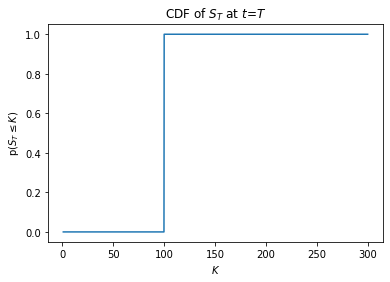

In [60]:
final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['PDF']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']=final_dict[i]['PDF']*final_dict[i]['δ']

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(f"probaility space sums to: {df['probability'].sum()*100}%")
display(df)

plt.plot(df.K_mid,df.probability)
plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t$=$T$')
plt.show()

plt.plot(df.K_mid,df.probability.cumsum())
plt.xlabel('$K$')
plt.ylabel('p($S_T \leq K$)')
plt.title('CDF of $S_T$ at $t$=$T$')
plt.show()

probaility space sums to: 99.88623842152522%


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,PDF,probability
0,100,0.03,0.3,0.1,0.9,1.0,1.1,1.5,99.139602,99.044003,98.948403,-1.486495e-14,-1.486495e-12,-1.486495e-13
1,100,0.03,0.3,0.1,1.0,1.1,1.2,1.5,99.044003,98.948403,98.852803,1.486495e-14,1.486495e-12,1.486495e-13
2,100,0.03,0.3,0.1,1.1,1.2,1.3,1.5,98.948403,98.852803,98.757203,-1.486495e-14,-1.486495e-12,-1.486495e-13
3,100,0.03,0.3,0.1,1.2,1.3,1.4,1.5,98.852803,98.757203,98.661604,1.486495e-14,1.486495e-12,1.486495e-13
4,100,0.03,0.3,0.1,1.3,1.4,1.5,1.5,98.757203,98.661604,98.566004,-1.486495e-14,-1.486495e-12,-1.486495e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,100,0.03,0.3,0.1,299.5,299.6,299.7,1.5,0.037679,0.037568,0.037458,3.485791e-07,3.485791e-05,3.485791e-06
2987,100,0.03,0.3,0.1,299.6,299.7,299.8,1.5,0.037568,0.037458,0.037348,3.474993e-07,3.474993e-05,3.474993e-06
2988,100,0.03,0.3,0.1,299.7,299.8,299.9,1.5,0.037458,0.037348,0.037239,3.464231e-07,3.464231e-05,3.464231e-06
2989,100,0.03,0.3,0.1,299.8,299.9,300.0,1.5,0.037348,0.037239,0.037130,3.453502e-07,3.453502e-05,3.453502e-06


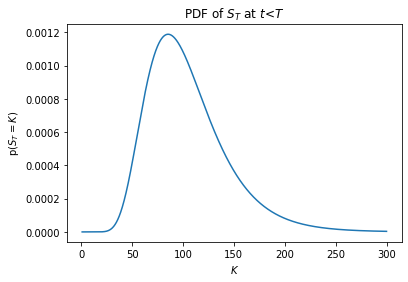

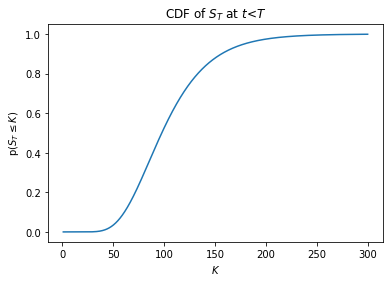

In [61]:
T=3 #Time of Maturity
t=T*0.5 #Current Time
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['PDF']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']=final_dict[i]['PDF']*final_dict[i]['δ']

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(f"probaility space sums to: {df['probability'].sum()*100}%")
display(df)

plt.plot(df.K_mid,df.probability)
plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t$<$T$')
plt.show()

plt.plot(df.K_mid,df.probability.cumsum())
plt.xlabel('$K$')
plt.ylabel('p($S_T \leq K$)')
plt.title('CDF of $S_T$ at $t$<$T$')
plt.show()

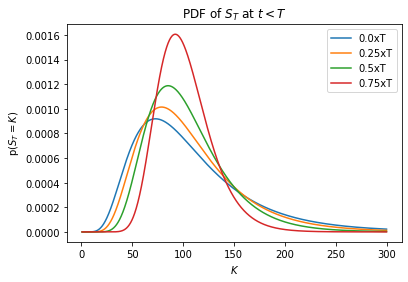

In [62]:
T=3 #Time of Maturity
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist
t_range=np.arange(0,1,0.25)
for tau in t_range:
  final_dict={}
  for i in range(len(strike_range)):
    final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-T*tau,}
    C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i],call=call).price
    C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]-delta,call=call).price
    C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]+delta,call=call).price
    final_dict[i]['C_low']=C_low
    final_dict[i]['C_mid']=C_mid
    final_dict[i]['C_high']=C_high
    final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-T*tau))
    final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
    final_dict[i]['probability']*=(final_dict[i]['δ'])

  df=pd.DataFrame.from_dict(final_dict,orient='index')
  plt.plot(df.K_mid,df.probability,label=f'{round(tau,2)}xT')

plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t < T$')
plt.legend()
plt.show()


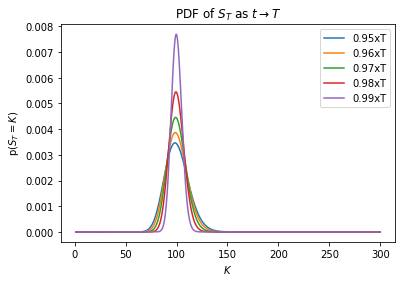

In [63]:
T=3 #Time of Maturity
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist
t_range=np.arange(0.95,0.99,0.01)
for tau in t_range:
  final_dict={}
  for i in range(len(strike_range)):
    final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-T*tau,}
    C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i],call=call).price
    C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]-delta,call=call).price
    C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]+delta,call=call).price
    final_dict[i]['C_low']=C_low
    final_dict[i]['C_mid']=C_mid
    final_dict[i]['C_high']=C_high
    final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-T*tau))
    final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
    final_dict[i]['probability']*=(final_dict[i]['δ'])

  df=pd.DataFrame.from_dict(final_dict,orient='index')
  plt.plot(df.K_mid,df.probability,label=f'{round(tau,2)}xT')

plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ as $t \\rightarrow T$')
plt.legend()
plt.show()


### From Variance to Probabilites: an Example 

In [ ]:
T=2 #Time of Maturity
#t=T #Current Time
t=0#.25
St=100 #Current Stock Price

r=0.03 #annualized riskless rate 
sigma=0.3 #annualized volatility
F=St*np.exp(r*(T-t)) #Fair Fwd Price
call=True
dK = 1 #1
delta = dK
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

term_price=110 

def butt_spread(S,K,delta,r,sigma,t,T):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_price(S,K,r,sigma,t,T):
    call=True
    bs_price=BSOPM_Class(S0=S,r=r,sigma=sigma,t=t,T=T,K=K,call=call).price
    return bs_price
  payoffs=np.array([call_price(S,k,r,sigma,t,T) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

def replic_func(S,F,T):
  g=S/F-1
  g-=np.log(S/F)
  g*=2/T
  return g 

expected_var=replic_func(St,F,T)*np.exp(r*(T-t))

print(f'Expected Variance: {expected_var}')


final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['PDF']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']= final_dict[i]['PDF']*final_dict[i]['δ']

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(f"probability space sums to: {df['probability'].sum()*100}%")
print(f"probability ST={term_price}={df[df.K_mid==term_price].probability.values[0]*100}%")
display(df[df.K_mid==term_price])


In [75]:
term_price_low=90
term_price_high=110
print(f"probability({term_price_low}<=ST<={term_price_high})={df[df.K_mid.between(90,110)].probability.sum()*100}%")
display(df[df.K_mid.between(term_price_low,term_price_high)])

probability(90<=ST<=110)=19.585568470852746%


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,PDF,probability
89,100,0.03,0.3,1,89,90,91,2,24.825564,24.283442,23.751005,0.010284,0.010284,0.010284
90,100,0.03,0.3,1,90,91,92,2,24.283442,23.751005,23.228188,0.010215,0.010215,0.010215
91,100,0.03,0.3,1,91,92,93,2,23.751005,23.228188,22.714920,0.010140,0.010140,0.010140
92,100,0.03,0.3,1,92,93,94,2,23.228188,22.714920,22.211127,0.010060,0.010060,0.010060
93,100,0.03,0.3,1,93,94,95,2,22.714920,22.211127,21.716727,0.009975,0.009975,0.009975
94,100,0.03,0.3,1,94,95,96,2,22.211127,21.716727,21.231636,0.009885,0.009885,0.009885
95,100,0.03,0.3,1,95,96,97,2,21.716727,21.231636,20.755767,0.009791,0.009791,0.009791
96,100,0.03,0.3,1,96,97,98,2,21.231636,20.755767,20.289027,0.009694,0.009694,0.009694
97,100,0.03,0.3,1,97,98,99,2,20.755767,20.289027,19.831321,0.009592,0.009592,0.009592
98,100,0.03,0.3,1,98,99,100,2,20.289027,19.831321,19.382549,0.009487,0.009487,0.009487
